In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad
class FNN(nn.Module):
    def __init__(self,layers,activation,in_tf=None,out_tf=None):
        super().__init__()
        self.activation = activation
        self.linears = nn.ModuleList()
        self.in_tf = in_tf
        self.out_tf = out_tf
        # weight initialization
        for i in range(1,len(layers)):
            self.linears.append(nn.Linear(layers[i-1],layers[i]))
            nn.init.xavier_uniform_(self.linears[-1].weight)
            nn.init.zeros_(self.linears[-1].bias)
                      
    def forward(self,inputs):
        X = inputs
        # input transformation
        if self.in_tf:
            X = self.in_tf(X)
        # linear layers    
        for linear in self.linears[:-1]:
            X = self.activation(linear(X))
        # last layer, no activation
        X = self.linears[-1](X)
        # output transformation
        if self.out_tf:
            X = self.out_tf(X)
        return X

In [2]:
import numpy as np
data= np.load("/home/jagadeeswaran/some_Partial_data_final.npy")
print(len(data))

174


In [3]:
import torch
import torch.nn as nn
import time
l_history_all= []
def loss(f,target=None):
    if target == None:
        return torch.sum(torch.square(f))/f.shape[0]
    if isinstance(target,float):
        return torch.sum(torch.square(f-target))/f.shape[0]
    else:
        return nn.MSELoss()(f,target)

    
def train(net,PDE,BC,point_sets,flags,iterations=50000,lr=5e-4,info_num=100,
         test_in = None, test_out=None,w=[1.,1.,1.,1.],inv_params=[]):
    
    if inv_params == []:
        params = net.parameters()
    else:
        params = (list(net.parameters())+inv_params)
    optimizer = torch.optim.Adam(params,lr=lr)
    
    n_bc = 0
    n_ic = 0
    n_PDE = 0
    n_data =0
    for points,flag in zip(point_sets,flags):
        if flag[0] == 'BC':
            n_bc += points.shape[0]
        if flag[0] == 'IC':
            n_ic += points.shape[0]
        if flag[0] == 'domain':
            n_PDE += points.shape[0]
        if flag[0] == 'data':
            n_data += points.shape[0]
            
    start_time = time.time()
    
    l_history = []
    if test_in != None:
        err_history = []
    for epoch in range(iterations):
        optimizer.zero_grad()
        l_BC = 0
        l_IC = 0
        l_PDE = 0
        l_data = 0
    
        for points,flag in zip(point_sets,flags):
            if flag[0] == 'BC':
                f = BC(points[:,0:1],points[:,1:2],points[:,2:3],points[:,3:4],net,flag[1])
                l_BC += loss(f)*points.shape[0]/n_bc
            if flag[0] == 'IC':
                pred = net(points)
                l_IC += loss(pred,flag[1])*points.shape[0]/n_ic
            if flag[0] == 'data':
                pred = net(points)
                l_data += loss(pred,flag[1])*points.shape[0]/n_data
            if flag[0] == 'domain':
                f = PDE(points[:,0:1],points[:,1:2],points[:,2:3],points[:,3:4],net)
                l_PDE += loss(f)*points.shape[0]/n_PDE
            
        
        if n_data == 0:
            cost = (w[0]*l_BC+w[1]*l_IC+w[2]*l_PDE)/3 #weighted
            l_history.append([cost.item(),
                      l_BC.item(),
                      l_IC.item(),
                      l_PDE.item()])
            
            if epoch%info_num == 0:
                if test_in != None:
                    T_pred = net(test_in)
                    Test_err = loss(T_pred,test_out)
                    err_history.append(Test_err.item())
                    elapsed = time.time() - start_time
                    print('It: %d, Loss: %.3e, BC: %.3e, IC: %.3e, PDE: %.3e, Test: %.3e, Time: %.2f' 
                          % (epoch, cost, l_BC, l_IC, l_PDE, Test_err, elapsed))
                    start_time = time.time()
                else:
                    elapsed = time.time() - start_time
                    print('It: %d, Loss: %.3e, BC: %.3e, IC: %.3e, PDE: %.3e, Time: %.2f' 
                          % (epoch, cost, l_BC, l_IC, l_PDE,elapsed))
                    start_time = time.time()
                                        
        else:
            cost = (w[0]*l_BC+w[1]*l_IC+w[2]*l_PDE+w[3]*l_data)/4 #weighted
            l_history.append([cost.item(),
                              l_BC.item(),
                              l_IC.item(),
                              l_PDE.item(),
                              l_data.item()])
            
            l_history_all.append([cost.item(),
                              l_BC.item(),
                              l_IC.item(),
                              l_PDE.item(),
                              l_data.item()])
            
            if epoch%info_num == 0:
                if test_in != None:
                    T_pred = net(test_in)
                    Test_err = loss(T_pred,test_out)
                    err_history.append(Test_err.item())
                    elapsed = time.time() - start_time
                    print('It: %d, Loss: %.3e, BC: %.3e, IC: %.3e, PDE: %.3e, Data: %.3e, Test: %.3e, Time: %.2f' 
                          % (epoch, cost, l_BC, l_IC, l_PDE, l_data,Test_err, elapsed))
                    start_time = time.time()
                else:
                    elapsed = time.time() - start_time
                    print('It: %d, Loss: %.3e, BC: %.3e, IC: %.3e, PDE: %.3e, Data: %.3e, Time: %.2f' 
                          % (epoch, cost, l_BC, l_IC, l_PDE, l_data, elapsed))
                    start_time = time.time()
                
                if inv_params!=[]:
                    for value in inv_params:
                        print(value.item())
                    
            
        cost.backward() 
        optimizer.step()
    
    return l_history


In [4]:
import numpy as np

def sampling_uniform(res,x_min,x_max,loc,t,e=0.05):
    if isinstance(res,float):
        res = [res,res,res]
    if loc == '-x':
        yp = np.linspace(x_min[1],x_max[1],round((x_max[1]-x_min[1])/res[1]) + 1)
        zp = np.linspace(x_min[2],x_max[2],round((x_max[2]-x_min[2])/res[2]) + 1)
        grid = np.meshgrid(yp,zp)
        yp = grid[0].flatten()
        zp = grid[1].flatten()
        xp = np.ones_like(yp)*x_min[0]
        x = np.vstack((xp,yp,zp)).T
    if loc == '+x':
        yp = np.linspace(x_min[1],x_max[1],round((x_max[1]-x_min[1])/res[1]) + 1) 
        zp = np.linspace(x_min[2],x_max[2],round((x_max[2]-x_min[2])/res[2]) + 1)
        grid = np.meshgrid(yp,zp)
        yp = grid[0].flatten()
        zp = grid[1].flatten()
        xp = np.ones_like(yp)*x_max[0]
        x = np.vstack((xp,yp,zp)).T
    if loc == '-y':
        xp = np.linspace(x_min[0],x_max[0],round((x_max[0]-x_min[0])/res[0]) + 1)
        zp = np.linspace(x_min[2],x_max[2],round((x_max[2]-x_min[2])/res[2]) + 1)
        grid = np.meshgrid(xp,zp)
        xp = grid[0].flatten()
        zp = grid[1].flatten()
        yp = np.ones_like(xp)*x_min[1]
        x = np.vstack((xp,yp,zp)).T
    if loc == '+y':
        xp = np.linspace(x_min[0],x_max[0],round((x_max[0]-x_min[0])/res[1]) + 1)
        zp = np.linspace(x_min[2],x_max[2],round((x_max[2]-x_min[2])/res[2]) + 1)
        grid = np.meshgrid(xp,zp)
        xp = grid[0].flatten()
        zp = grid[1].flatten()
        yp = np.ones_like(xp)*x_max[1]
        x = np.vstack((xp,yp,zp)).T
    if loc == '-z':
        xp = np.linspace(x_min[0],x_max[0],round((x_max[0]-x_min[0])/res[0]) + 1)
        yp = np.linspace(x_min[1],x_max[1],round((x_max[1]-x_min[1])/res[1]) + 1)
        grid = np.meshgrid(xp,yp)
        xp = grid[0].flatten()
        yp = grid[1].flatten()
        zp = np.ones_like(xp)*x_min[2]
        x = np.vstack((xp,yp,zp)).T
    if loc == '+z':
        xp = np.linspace(x_min[0],x_max[0],round((x_max[0]-x_min[0])/res[0]) + 1) 
        yp = np.linspace(x_min[1],x_max[1],round((x_max[1]-x_min[1])/res[1]) + 1) 
        grid = np.meshgrid(xp,yp)
        xp = grid[0].flatten()
        yp = grid[1].flatten()
        zp = np.ones_like(xp)*x_max[2]
        x = np.vstack((xp,yp,zp)).T
    if loc == 'domain':
        xp = np.linspace(x_min[0]+e,x_max[0]-e,round((x_max[0]-x_min[0])/res[0]) + 1) 
        yp = np.linspace(x_min[1]+e,x_max[1]-e,round((x_max[1]-x_min[1])/res[1]) + 1)
        zp = np.linspace(x_min[2]+e,x_max[2]-e,round((x_max[2]-x_min[2])/res[2]) + 1)
        grid = np.meshgrid(xp,yp,zp)
        xp = grid[0].flatten()
        yp = grid[1].flatten()
        zp = grid[2].flatten()
        x = np.vstack((xp,yp,zp)).T
        
    xt = []
    num = x.shape[0]
    for ti in t:
        xt.append(np.hstack((x, np.full([num,1], ti))))
    xt = np.vstack(xt) 
    return xt, xt.shape[0]



def sampling_uniform_2D(res,x_min,x_max,loc,t,e=0.05):
    if isinstance(res,float):
        res = [res,res,res]
    if loc == '-x':
        yp = np.linspace(x_min[1],x_max[1],round((x_max[1]-x_min[1])/res[1]) + 1)
        xp = np.ones_like(yp)*x_min[0]
        x = np.vstack((xp,yp)).T
    if loc == '+x':
        yp = np.linspace(x_min[1],x_max[1],round((x_max[1]-x_min[1])/res[1]) + 1) 
        xp = np.ones_like(yp)*x_max[0]
        x = np.vstack((xp,yp)).T
    if loc == '-y':
        xp = np.linspace(x_min[0],x_max[0],round((x_max[0]-x_min[0])/res[0]) + 1)
        yp = np.ones_like(xp)*x_min[1]
        x = np.vstack((xp,yp)).T
    if loc == '+y':
        xp = np.linspace(x_min[0],x_max[0],round((x_max[0]-x_min[0])/res[1]) + 1)
        yp = np.ones_like(xp)*x_max[1]
        x = np.vstack((xp,yp)).T
    if loc == 'domain':
        xp = np.linspace(x_min[0]+e,x_max[0]-e,round((x_max[0]-x_min[0])/res[0]) + 1) 
        yp = np.linspace(x_min[1]+e,x_max[1]-e,round((x_max[1]-x_min[1])/res[1]) + 1)
        grid = np.meshgrid(xp,yp)
        xp = grid[0].flatten()
        yp = grid[1].flatten()
        x = np.vstack((xp,yp)).T
    xt = []
    num = x.shape[0]
    for ti in t:
        xt.append(np.hstack((x, np.full([num,1], ti))))
    xt = np.vstack(xt) 
    return xt, xt.shape[0]

In [5]:
import torch
from torch import device

# Check if accelerator is set to GPU
if torch.cuda.is_available():
    device = device("cuda:0")
else:
    device = device("cpu")

print("Using device:", device)


Using device: cuda:0


In [24]:
 # Define parameters
ar= 3.34
af=1.002
a= af+ar
b= 1.67
c= 1.67
v = 10.
U= 15.3
I= 120
eta = .9
ff= 0.46
fr= 2-ff


xmax = 40.0
xmin = 0.0
ymax = 10.0
ymin = 0.0
zmax = 6.0
zmin = 0.0
tmax = 3.0
tmin = 0.0
Cp = 0.6
k = 0.024
x0 = 5.0
y0 = 5.0
z0= 6.0
t_end = 3.0
h = 2e-5
emiss = 0.35
rho = 7.966e-3
Rboltz=5.6704e-14

x_max = np.array([xmax, ymax, zmax, tmax])
x_min = np.array([xmin, ymin, zmin, tmin])
X_max = torch.tensor(x_max, dtype=torch.float).to(device)
X_min = torch.tensor(x_min, dtype=torch.float).to(device)

T_ref = 298.15
T_range = 1773.15

In [7]:
def PDE(x,y,z,t,net):
    X = torch.cat([x,y,z,t],axis=-1)
    T = net(X)
    
    T_t = grad(T,t,create_graph=True,grad_outputs=torch.ones_like(T))[0]

    T_x = grad(T,x,create_graph=True,grad_outputs=torch.ones_like(T))[0]
    T_xx = grad(T_x,x,create_graph=True,grad_outputs=torch.ones_like(T_x))[0]
    
    T_y = grad(T,y,create_graph=True,grad_outputs=torch.ones_like(T))[0]
    T_yy = grad(T_y,y,create_graph=True,grad_outputs=torch.ones_like(T_y))[0]
    
    T_z = grad(T,z,create_graph=True,grad_outputs=torch.ones_like(T))[0]
    T_zz = grad(T_z,z,create_graph=True,grad_outputs=torch.ones_like(T_z))[0]
    k=  (0.01351*T + 10.03816)/1000
    Cp = (0.16242*T + 433.30551)/1000
    if torch.all(x - x0 - v * t > 0):
            r02 = ((x - x0 - v * t)**2 / af**2) + ((y - y0)**2 / b**2) + ((z - z0)**2 / c**2)
            q = (6 * ((3)**(1/3)) * ff * eta * U * I / (af * b * c * 3.14159 * 1.7724)) * torch.exp(-3 * r02)
    else:
            r02 = ((x - x0 - v * t)**2 / ar**2) + ((y - y0)**2 / b**2) + ((z - z0)**2 / c**2)
            q = (6 * ((3)**(1/3)) * fr * eta * U * I / (ar * b * c * 3.14159 * 1.7724)) * torch.exp(-3 * r02)
    f = rho*Cp*T_t - k*(T_xx+T_yy+T_zz)-q

    return f



In [8]:
def generate_points(p=[],f=[]):

    t = np.linspace(x_min[3]+0.01,x_max[3],61)

    # boundary points
    bound_x_neg,_ = sampling_uniform(1.,x_min,x_max,'-x',t)
    bound_x_pos,_ = sampling_uniform(1.,x_min,x_max,'+x',t)

    bound_y_neg,_ = sampling_uniform(1.,x_min,x_max,'-y',t)
    bound_y_pos,_ = sampling_uniform(1.,x_min,x_max,'+y',t)

    bound_z_neg,_ = sampling_uniform(1.,x_min,x_max,'-z',t)
    bound_z_pos,_ = sampling_uniform(1.,x_min,x_max,'+z',t)

    bound_z_pos_more = [] # more points for surface flux
    
    for ti in t:
        if ti<=t_end:
            zi,_ = sampling_uniform(.25,
                        [max(x0+ti*v-2*(af+ar),x_min[0]),max(x_min[1],y0-2*b),x_min[2]],
                        [min(x0+ti*v+2*(af+ar),x_max[0]),min(x_max[1],y0+2*b),x_max[2]],
                        '+z',[ti])
            bound_z_pos_more.append(zi)

    bound_z_pos_more = np.vstack(bound_z_pos_more)
    bound_z_pos = np.vstack((bound_z_pos,bound_z_pos_more))

    ### domain points
    domain_pts1,_ = sampling_uniform(2.,
                                     [x_min[0],x_min[1],x_min[2]],
                                     [x_max[0],x_max[1],x_max[2]-3.],'domain',t)

    domain_pts2,_ = sampling_uniform(1.,
                                     [x_min[0],x_min[1],x_max[2]-3.+.5],
                                     [x_max[0],x_max[1],x_max[2]-1.],'domain',t)

    domain_pts3 = []
    for ti in t:
        di,_ = sampling_uniform(.5,
                                [x_min[0],x_min[1],x_max[2]-1.+.25,],
                                [x_max[0],x_max[1],x_max[2]],'domain',[ti])
        domain_pts3.append(di)
    domain_pts3 = np.vstack(domain_pts3)
    domain_pts = np.vstack((domain_pts1,domain_pts2,domain_pts3))

    # initial points
    init_pts1,_ = sampling_uniform(2.,[x_min[0],x_min[1],x_min[2]],
                                   [x_max[0],x_max[1],x_max[2]],'domain',[0],e=0)
    # more points near the toolpath origin
    init_pts2,_ = sampling_uniform(.5,[x0-3,y0-2.5,x_max[2]-2],
                                   [x0+3,y0+2.5,x_max[2]],'domain',[0])
    
    init_pts = np.vstack((init_pts1,init_pts2))
    

    p.extend([torch.tensor(bound_x_neg,requires_grad=True,dtype=torch.float).to(device),
              torch.tensor(bound_x_pos,requires_grad=True,dtype=torch.float).to(device),
              torch.tensor(bound_y_neg,requires_grad=True,dtype=torch.float).to(device),
              torch.tensor(bound_y_pos,requires_grad=True,dtype=torch.float).to(device),
              torch.tensor(bound_z_neg,requires_grad=True,dtype=torch.float).to(device),
              torch.tensor(bound_z_pos,requires_grad=True,dtype=torch.float).to(device),
              torch.tensor(init_pts,requires_grad=True,dtype=torch.float).to(device),
              torch.tensor(domain_pts,requires_grad=True,dtype=torch.float).to(device)])
    f.extend([['BC','-x'],['BC','+x'],['BC','-y'],['BC','+y'],['BC','-z'],['BC','+z'],['IC',T_ref],['domain']])
    
    return p,f

In [9]:
def BC(x,y,z,t,net,loc):
    X = torch.cat([x,y,z,t],axis=-1)
    T = net(X)
    k=  (0.01351*T + 10.03816)/1000
    Cp = (0.16242*T + 433.30551)/1000
    
    if loc == '-x':
        T_x = grad(T,x,create_graph=True,grad_outputs=torch.ones_like(T))[0]
        return k*T_x - h*(T-T_ref) - Rboltz*emiss*(T**4-T_ref**4)
    if loc == '+x':
        T_x = grad(T,x,create_graph=True,grad_outputs=torch.ones_like(T))[0]
        return -k*T_x - h*(T-T_ref) - Rboltz*emiss*(T**4-T_ref**4)
    if loc == '-y':
        T_y = grad(T,y,create_graph=True,grad_outputs=torch.ones_like(T))[0]
        return k*T_y - h*(T-T_ref) - Rboltz*emiss*(T**4-T_ref**4)
    if loc == '+y':
        T_y = grad(T,y,create_graph=True,grad_outputs=torch.ones_like(T))[0]
        return -k*T_y - h*(T-T_ref) - Rboltz*emiss*(T**4-T_ref**4)
    if loc == '-z':
        T_t = grad(T,t,create_graph=True,grad_outputs=torch.ones_like(T))[0]
        return T_t
    if loc == '+z':
        T_z = grad(T, z, create_graph=True, grad_outputs=torch.ones_like(T))[0]
        return -k * T_z - h * (T - T_ref) - Rboltz * emiss * (T**4 - T_ref**4) 

In [10]:
def output_transform(X):
    X = T_range*nn.Softplus()(X)+ T_ref
    return X

def input_transform(X):
    X = 2.*(X-X_min)/(X_max-X_min) - 1.
    return X

In [11]:
def load_data(p,f,filename,num):
    data = np.load(filename)
    if num!= 0:
        np.random.shuffle(data)
        data = data[0:num,:]
    p.extend([torch.tensor(data[:,0:4],requires_grad=True,dtype=torch.float).to(device)])
    f.extend([['data',torch.tensor(data[:,4:5],requires_grad=True,dtype=torch.float).to(device)]])
    return p,f

In [12]:
    
iterations = 50000
lr = 2e-3

net = FNN([4,64,64,64,1],nn.Tanh(),in_tf=input_transform,out_tf=output_transform)
net.to(device)

point_sets,flags = generate_points([],[])
point_sets,flags = load_data(point_sets,flags,"/home/jagadeeswaran/some_Partial_data_final.npy",0)

In [ ]:
import matplotlib.pyplot as plt

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
l_history = train(net,PDE,BC,point_sets,flags,iterations,lr=lr,info_num=100,w=[1,1e-1,1., 3.0])


end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end))

def plot_loss_curves(l_history, filename="loss_curves.png"):
    l_history = np.array(l_history)
    plt.figure(figsize=(10, 8))
    plt.plot(l_history[:, 0], label='Total Loss')
    plt.plot(l_history[:, 1], label='BC Loss')
    plt.plot(l_history[:, 2], label='IC Loss')
    plt.plot(l_history[:, 3], label='PDE Loss')
    plt.plot(l_history[:, 4], label='Data Loss')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.savefig(filename)
    plt.close()

plot_loss_curves(l_history, filename="/home/jagadeeswaran/Hybrid_final_thesis/loss_curves.png")
torch.save(net.state_dict(),'/home/jagadeeswaran/Hybrid_final_thesis/Hybrid_partial_data_in_l-ded_model.pt')

In [25]:
import torch
import torch.nn as nn
import numpy as np

# Define your FNN class
class FNN(nn.Module):
    def __init__(self, layers, activation, in_tf=None, out_tf=None):
        super().__init__()
        self.activation = activation
        self.linears = nn.ModuleList()
        self.in_tf = in_tf
        self.out_tf = out_tf
        # Weight initialization
        for i in range(1, len(layers)):
            self.linears.append(nn.Linear(layers[i-1], layers[i]))
            nn.init.xavier_uniform_(self.linears[-1].weight)
            nn.init.zeros_(self.linears[-1].bias)

    def forward(self, inputs):
        X = inputs
        # Input transformation
        if self.in_tf:
            X = self.in_tf(X)
        # Linear layers
        for linear in self.linears[:-1]:
            X = self.activation(linear(X))
        # Last layer, no activation
        X = self.linears[-1](X)
        # Output transformation
        if self.out_tf:
            X = self.out_tf(X)
        return X

# Define your PDE, BC, and generate_points functions here

# Define device and other parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_max = np.array([40., 10., 6., 3.])
x_min = np.array([0., 0., 0., 0.])
X_max = torch.tensor(x_max, dtype=torch.float).to(device)
X_min = torch.tensor(x_min, dtype=torch.float).to(device)

In [26]:
# Define your laser parameters, temperature parameters, and material parameters here

iterations = 100000
lr = 2e-4

# Create an instance of the model
model = FNN([4, 64, 64, 64, 1], nn.Tanh(), in_tf=input_transform, out_tf=output_transform)

# Load the saved model state dictionary
model.load_state_dict(torch.load('/home/jagadeeswaran/Hybrid_partial_data_in_l-ded_model (2).pt'))
# Set the model to the same device as input_data
model.to(device)

# Set the model to evaluation mode (important if using dropout or batch normalization layers)
model.eval()

# Prepare input data (replace with your actual input data)
input_data = torch.tensor([
    [5.0, 5.0, 6.0, 0.1]  
], dtype=torch.float).to(device)

# Make predictions
with torch.no_grad():
    output = model(input_data)

# Post-process predictions if necessary
# Use the predictions in your application
output

tensor([[3558.1855]], device='cuda:0')

In [27]:
import matplotlib.pyplot as plt
def plot_predictions_3D(net, X_min, X_max, T_range, T_ref, epoch, filename="/home/jagadeeswaran/Hybrid_final_thesis/hybrid_predictions_3D.png"):
    x = np.linspace(X_min.cpu().numpy()[0], X_max.cpu().numpy()[0], 50)
    y = np.linspace(X_min.cpu().numpy()[1], X_max.cpu().numpy()[1], 50)
    z = np.linspace(X_min.cpu().numpy()[2], X_max.cpu().numpy()[2], 50)
    t_vals = [0, 1, 2, 3]

    fig = plt.figure(figsize=(20, 15), dpi=300)  # Increase figure size and DPI for higher resolution

    for i, t in enumerate(t_vals):
        ax = fig.add_subplot(2, 2, i + 1, projection='3d')
        X, Y, Z = np.meshgrid(x, y, z)
        points = np.stack([X.ravel(), Y.ravel(), Z.ravel(), np.full_like(X.ravel(), t)], axis=-1)
        points = torch.tensor(points, dtype=torch.float32).to(next(net.parameters()).device)
        predictions = net(points).detach().cpu().numpy().reshape(50, 50, 50)

        sc = ax.scatter(X, Y, Z, c=predictions.ravel(), cmap='jet', marker='o', s=20, alpha=0.6)
        cbar = fig.colorbar(sc, ax=ax, label='U(t,x,y,z)')
        cbar.ax.tick_params(labelsize=12)
        ax.set_title(f"Time: {t}", fontsize=15)
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('y', fontsize=12)
        ax.set_zlabel('z', fontsize=12)

        # Maintain aspect ratio
        xlim = ax.get_xlim3d()
        ylim = ax.get_ylim3d()
        zlim = ax.get_zlim3d()

        ax.set_box_aspect([xlim[1] - xlim[0], ylim[1] - ylim[0], zlim[1] - zlim[0]])  # Aspect ratio is 1:1:1

    plt.suptitle(f"3D Predictions at Epoch {epoch}", fontsize=18)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.close()

# After training, call the function to plot predictions
epoch = iterations  # Assuming this is the final epoch after training
plot_predictions_3D(model, X_min, X_max, T_range, T_ref, epoch)


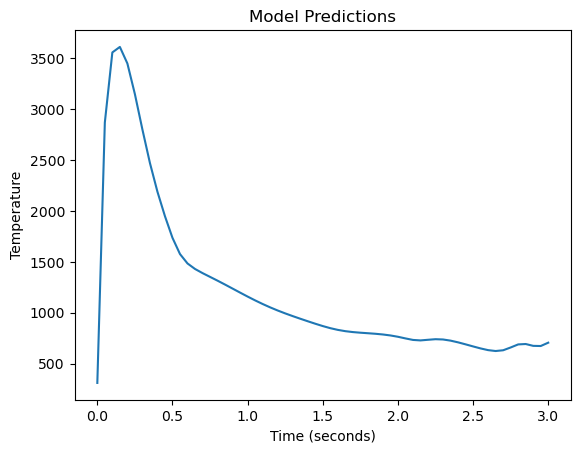

In [29]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_input_tensor(total_time, time_step):
    num_steps = int(total_time / time_step) + 1
    input_data = torch.zeros(num_steps, 4)
    for i in range(num_steps):
        input_data[i] = torch.tensor([5.0, 5.0, 6.0, i * time_step], dtype=torch.float)
    return input_data

# Get user input for total time duration and time step
total_time = 3.0
time_step = 0.05

# Generate input tensor
input_data = generate_input_tensor(total_time, time_step)

# Assuming 'device' is defined elsewhere in your code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the tensor to the device
input_data = input_data.to(device)

# Make predictions
with torch.no_grad():
    Temperature = []
    for data_point in input_data:
        Temperature.append(model(data_point.unsqueeze(0)))
    Temperature = torch.cat(Temperature, dim=0)

# Move the output tensor to CPU and convert it to a NumPy array
Temperature_np = Temperature.cpu().detach().numpy().copy()

# Plot the results
plt.plot(np.linspace(0.0, total_time, len(input_data)), Temperature_np)
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature')
plt.title('Model Predictions')
plt.show()




Selected Times: [0.0, 0.0298408, 0.0596816, 0.0895224, 0.119363, 0.149204, 0.179045, 0.208886, 0.253647, 0.298408, 0.343169, 0.387931, 0.432692, 0.477453, 0.522214, 0.566975, 0.611737, 0.656498, 0.701259, 0.74602, 0.790782, 0.835543, 0.880304, 0.925065, 0.969826, 1.01459, 1.05935, 1.10411, 1.14887, 1.19363, 1.23839, 1.28315, 1.32792, 1.37268, 1.41744, 1.4622, 1.50696, 1.55172, 1.59648, 1.64124, 1.68601, 1.73077, 1.77553, 1.82029, 1.86505, 1.90981, 1.95457, 1.99933, 2.0441, 2.08886, 2.13362, 2.17838, 2.22314, 2.2679, 2.31266, 2.35742, 2.40219, 2.44695, 2.49171, 2.53647, 2.58123, 2.62599, 2.67075, 2.71551, 2.76028, 2.80504, 2.8498, 2.89456, 2.93932, 2.98408, 3.0, 3.05887]
Actual Temperatures: [298.15, 1005.35, 1820.84, 2918.44, 3658.27, 4170.63, 4452.92, 4540.34, 4364.82, 4005.24, 3572.47, 3147.0, 2774.38, 2471.2, 2234.12, 2053.25, 1915.16, 1813.79, 1733.67, 1686.78, 1636.24, 1584.1, 1515.08, 1438.66, 1373.84, 1318.7, 1269.93, 1226.51, 1187.4, 1151.98, 1119.75, 1090.29, 1063.28, 1038.42,

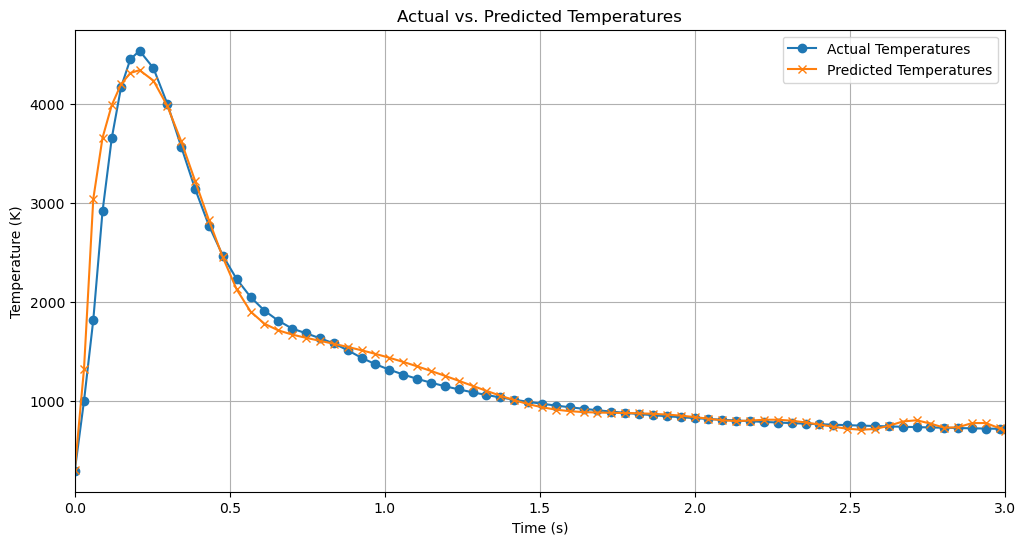

In [30]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Provided actual temperature data points (filtered to include only up to 3 seconds)
data_points = {
    0.0: 298.15,
    0.0298408: 1005.35,
    0.0596816: 1820.84,
    0.0895224: 2918.44,
    0.119363: 3658.27,
    0.149204: 4170.63,
    0.179045: 4452.92,
    0.208886: 4540.34,
    0.253647: 4364.82,
    0.298408: 4005.24,
    0.343169: 3572.47,
    0.387931: 3147.0,
    0.432692: 2774.38,
    0.477453: 2471.2,
    0.522214: 2234.12,
    0.566975: 2053.25,
    0.611737: 1915.16,
    0.656498: 1813.79,
    0.701259: 1733.67,
    0.74602: 1686.78,
    0.790782: 1636.24,
    0.835543: 1584.1,
    0.880304: 1515.08,
    0.925065: 1438.66,
    0.969826: 1373.84,
    1.01459: 1318.7,
    1.05935: 1269.93,
    1.10411: 1226.51,
    1.14887: 1187.4,
    1.19363: 1151.98,
    1.23839: 1119.75,
    1.28315: 1090.29,
    1.32792: 1063.28,
    1.37268: 1038.42,
    1.41744: 1015.49,
    1.4622: 994.298,
    1.50696: 974.662,
    1.55172: 956.433,
    1.59648: 939.487,
    1.64124: 923.713,
    1.68601: 909.009,
    1.73077: 895.288,
    1.77553: 882.472,
    1.82029: 870.489,
    1.86505: 859.275,
    1.90981: 848.773,
    1.95457: 838.931,
    1.99933: 829.702,
    2.0441: 821.04,
    2.08886: 812.908,
    2.13362: 805.269,
    2.17838: 798.089,
    2.22314: 791.339,
    2.2679: 784.989,
    2.31266: 779.014,
    2.35742: 773.389,
    2.40219: 768.094,
    2.44695: 763.106,
    2.49171: 758.407,
    2.53647: 753.979,
    2.58123: 749.805,
    2.62599: 745.87,
    2.67075: 742.159,
    2.71551: 738.66,
    2.76028: 735.36,
    2.80504: 732.247,
    2.8498: 729.31,
    2.89456: 726.54,
    2.93932: 723.926,
    2.98408: 721.461,
    3.0: 720.602,
    3.05887: 717.66
}

# Ensure all selected times are present in the data_points dictionary
selected_time_values = [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0]

# Filter selected_time_values to ensure they exist in data_points keys
selected_time_values = [time for time in selected_time_values if time in data_points]

# Generate the desired format for domain points
formatted_data = [[6.0, 5.0, 6.0, t] for t in sorted(data_points.keys())]  # Ensure the keys are sorted

# Convert to tensor
input_data = torch.tensor(formatted_data, dtype=torch.float32)


input_data = input_data.to(device)

# Assuming 'model' is defined and loaded elsewhere in your code

# Make predictions
with torch.no_grad():
    Temperature = []
    for data_point in input_data:
        Temperature.append(model(data_point.unsqueeze(0)))
    Temperature = torch.cat(Temperature, dim=0)

# Move the output tensor to CPU and convert it to a NumPy array
Temperature_np = Temperature.cpu().detach().numpy().copy()

# Extract the predicted temperatures for the selected points
predicted_temperatures = [Temperature_np[list(data_points.keys()).index(time)][0] for time in sorted(data_points.keys())]

# Extract the actual temperatures for the selected points
actual_temperatures = [data_points[time] for time in sorted(data_points.keys())]

# Output the selected times, actual temperatures, and predictions as lists
print("Selected Times:", list(data_points.keys()))
print("Actual Temperatures:", actual_temperatures)
print("Predicted Temperatures:", predicted_temperatures)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(list(data_points.keys()), list(data_points.values()), 'o-', label='Actual Temperatures')
plt.plot(sorted(data_points.keys()), Temperature_np, 'x-', label='Predicted Temperatures')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Actual vs. Predicted Temperatures')
plt.grid(True)
plt.xlim(0, 3)
plt.show()


Selected Times: [0.0, 0.0298408, 0.0596816, 0.0895224, 0.119363, 0.149204, 0.179045, 0.208886, 0.253647, 0.298408, 0.343169, 0.387931, 0.432692, 0.477453, 0.522214, 0.566975, 0.611737, 0.656498, 0.701259, 0.74602, 0.790782, 0.835543, 0.880304, 0.925065, 0.969826, 1.01459, 1.05935, 1.10411, 1.14887, 1.19363, 1.23839, 1.28315, 1.32792, 1.37268, 1.41744, 1.4622, 1.50696, 1.55172, 1.59648, 1.64124, 1.68601, 1.73077, 1.77553, 1.82029, 1.86505, 1.90981, 1.95457, 1.99933, 2.0441, 2.08886, 2.13362, 2.17838, 2.22314, 2.2679, 2.31266, 2.35742, 2.40219, 2.44695, 2.49171, 2.53647, 2.58123, 2.62599, 2.67075, 2.71551, 2.76028, 2.80504, 2.8498, 2.89456, 2.93932, 2.98408, 3.0, 3.05887]
Actual Temperatures: [298.15, 336.718, 472.098, 789.748, 1305.22, 1985.9, 3066.5, 3856.92, 4533.12, 4748.04, 4621.58, 4280.6, 3841.8, 3395.02, 2994.24, 2661.34, 2396.64, 2191.54, 2033.37, 1911.85, 1820.84, 1750.64, 1704.16, 1667.49, 1623.11, 1575.28, 1507.13, 1436.19, 1375.68, 1324.21, 1278.91, 1238.41, 1201.88, 1168.73

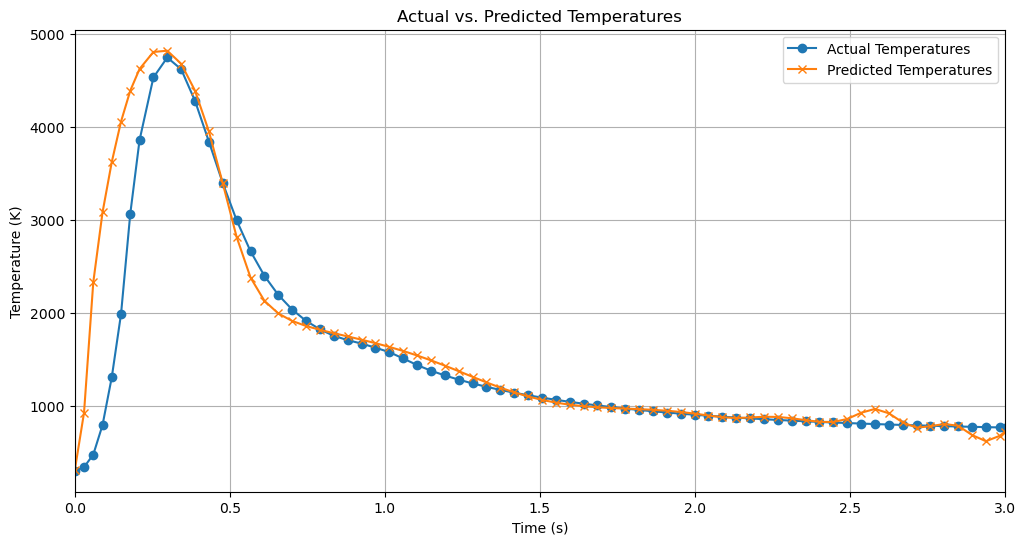

In [31]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Provided actual temperature data points (filtered to include only up to 3 seconds)
data_points = {
    0.0: 298.15,
    0.0298408: 336.718,
    0.0596816: 472.098,
    0.0895224: 789.748,
    0.119363: 1305.22,
    0.149204: 1985.9,
    0.179045: 3066.5,
    0.208886: 3856.92,
    0.253647: 4533.12,
    0.298408: 4748.04,
    0.343169: 4621.58,
    0.387931: 4280.6,
    0.432692: 3841.8,
    0.477453: 3395.02,
    0.522214: 2994.24,
    0.566975: 2661.34,
    0.611737: 2396.64,
    0.656498: 2191.54,
    0.701259: 2033.37,
    0.74602: 1911.85,
    0.790782: 1820.84,
    0.835543: 1750.64,
    0.880304: 1704.16,
    0.925065: 1667.49,
    0.969826: 1623.11,
    1.01459: 1575.28,
    1.05935: 1507.13,
    1.10411: 1436.19,
    1.14887: 1375.68,
    1.19363: 1324.21,
    1.23839: 1278.91,
    1.28315: 1238.41,
    1.32792: 1201.88,
    1.37268: 1168.73,
    1.41744: 1138.48,
    1.4622: 1110.76,
    1.50696: 1085.27,
    1.55172: 1061.77,
    1.59648: 1040.04,
    1.64124: 1019.9,
    1.68601: 1001.2,
    1.73077: 983.801,
    1.77553: 967.592,
    1.82029: 952.468,
    1.86505: 938.339,
    1.90981: 925.125,
    1.95457: 912.755,
    1.99933: 901.163,
    2.0441: 890.291,
    2.08886: 880.087,
    2.13362: 870.502,
    2.17838: 861.493,
    2.22314: 853.019,
    2.2679: 845.044,
    2.31266: 837.534,
    2.35742: 830.458,
    2.40219: 823.788,
    2.44695: 817.498,
    2.49171: 811.563,
    2.53647: 805.961,
    2.58123: 800.671,
    2.62599: 795.674,
    2.67075: 790.952,
    2.71551: 786.489,
    2.76028: 782.268,
    2.80504: 778.275,
    2.8498: 774.497,
    2.89456: 770.922,
    2.93932: 767.538,
    2.98408: 764.333,
    3.0: 763.216,
    3.0: 763.216,
    3.05887: 759.365
}

# Ensure all selected times are present in the data_points dictionary
selected_time_values = [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0]

# Filter selected_time_values to ensure they exist in data_points keys
selected_time_values = [time for time in selected_time_values if time in data_points]

# Generate the desired format for domain points
formatted_data = [[7.0, 5.0, 6.0, t] for t in sorted(data_points.keys())]  # Ensure the keys are sorted

# Convert to tensor
input_data = torch.tensor(formatted_data, dtype=torch.float32)

# Move the tensor to the device

input_data = input_data.to(device)

# Assuming 'model' is defined and loaded elsewhere in your code

# Make predictions
with torch.no_grad():
    Temperature = []
    for data_point in input_data:
        Temperature.append(model(data_point.unsqueeze(0)))
    Temperature = torch.cat(Temperature, dim=0)

# Move the output tensor to CPU and convert it to a NumPy array
Temperature_np = Temperature.cpu().detach().numpy().copy()

# Extract the predicted temperatures for all points
predicted_temperatures = [Temperature_np[i][0] for i in range(len(data_points))]

# Extract the actual temperatures for the selected points
actual_temperatures = [data_points[time] for time in data_points.keys()]

# Output the selected times, actual temperatures, and predictions as lists
print("Selected Times:", list(data_points.keys()))
print("Actual Temperatures:", actual_temperatures)
print("Predicted Temperatures:", predicted_temperatures)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(list(data_points.keys()), list(data_points.values()), 'o-', label='Actual Temperatures')
plt.plot(sorted(data_points.keys()), Temperature_np, 'x-', label='Predicted Temperatures')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Actual vs. Predicted Temperatures')
plt.grid(True)
plt.xlim(0, 3)
plt.show()


Selected Times: [0.0, 0.0298408, 0.0596816, 0.0895224, 0.119363, 0.149204, 0.179045, 0.208886, 0.253647, 0.298408, 0.343169, 0.387931, 0.432692, 0.477453, 0.522214, 0.566975, 0.611737, 0.656498, 0.701259, 0.74602, 0.790782, 0.835543, 0.880304, 0.925065, 0.969826, 1.01459, 1.05935, 1.10411, 1.14887, 1.19363, 1.23839, 1.28315, 1.32792, 1.37268, 1.41744, 1.4622, 1.50696, 1.55172, 1.59648, 1.64124, 1.68601, 1.73077, 1.77553, 1.82029, 1.86505, 1.90981, 1.95457, 1.99933, 2.0441, 2.08886, 2.13362, 2.17838, 2.22314, 2.2679, 2.31266, 2.35742, 2.40219, 2.44695, 2.49171, 2.53647, 2.58123, 2.62599, 2.67075, 2.71551, 2.76028, 2.80504, 2.8498, 2.89456, 2.93932, 2.98408, 3.0, 3.05887]
Actual Temperatures: [298.15, 299.932, 308.431, 334.384, 397.214, 529.714, 800.234, 1224.94, 2327.96, 3732.96, 4537.94, 4842.12, 4774.95, 4465.65, 4035, 3579.01, 3159.22, 2804.19, 2518.52, 2294.49, 2120.77, 1986.07, 1882.27, 1803.94, 1744.26, 1705.68, 1674.39, 1637.75, 1594.78, 1542.92, 1467.21, 1405.27, 1353.43, 1308.1

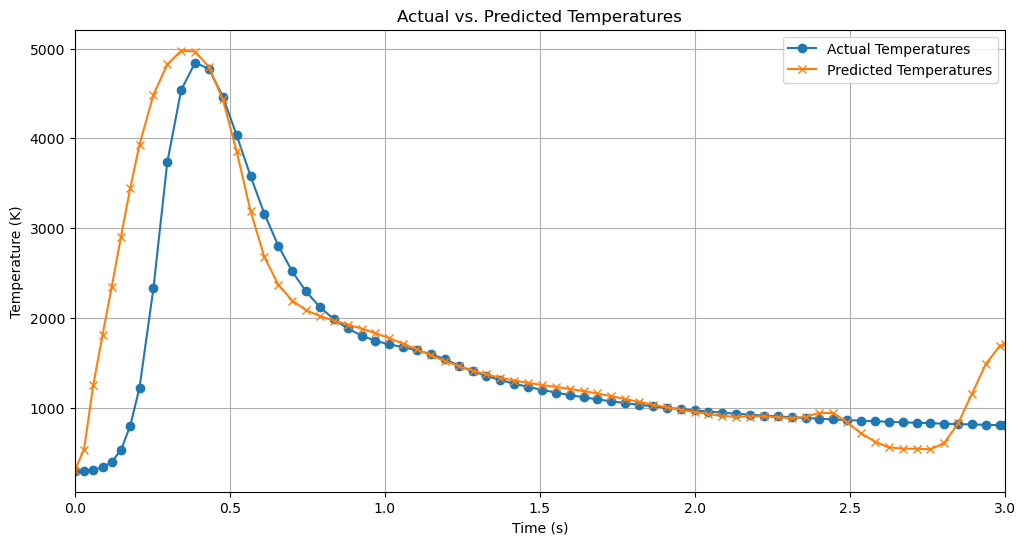

In [32]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Provided actual temperature data points (filtered to include only up to 3 seconds)
data_points = {
    0.0: 298.15,
    0.0298408: 299.932,
    0.0596816: 308.431,
    0.0895224: 334.384,
    0.119363: 397.214,
    0.149204: 529.714,
    0.179045: 800.234,
    0.208886: 1224.94,
    0.253647: 2327.96,
    0.298408: 3732.96,
    0.343169: 4537.94,
    0.387931: 4842.12,
    0.432692: 4774.95,
    0.477453: 4465.65,
    0.522214: 4035,
    0.566975: 3579.01,
    0.611737: 3159.22,
    0.656498: 2804.19,
    0.701259: 2518.52,
    0.74602: 2294.49,
    0.790782: 2120.77,
    0.835543: 1986.07,
    0.880304: 1882.27,
    0.925065: 1803.94,
    0.969826: 1744.26,
    1.01459: 1705.68,
    1.05935: 1674.39,
    1.10411: 1637.75,
    1.14887: 1594.78,
    1.19363: 1542.92,
    1.23839: 1467.21,
    1.28315: 1405.27,
    1.32792: 1353.43,
    1.37268: 1308.12,
    1.41744: 1267.78,
    1.4622: 1231.5,
    1.50696: 1198.63,
    1.55172: 1168.67,
    1.59648: 1141.23,
    1.64124: 1116,
    1.68601: 1092.73,
    1.73077: 1071.21,
    1.77553: 1051.26,
    1.82029: 1032.73,
    1.86505: 1015.47,
    1.90981: 999.384,
    1.95457: 984.362,
    1.99933: 970.315,
    2.0441: 957.162,
    2.08886: 944.836,
    2.13362: 933.271,
    2.17838: 922.412,
    2.22314: 912.207,
    2.2679: 902.608,
    2.31266: 893.574,
    2.35742: 885.065,
    2.40219: 877.044,
    2.44695: 869.48,
    2.49171: 862.343,
    2.53647: 855.603,
    2.58123: 849.236,
    2.62599: 843.218,
    2.67075: 837.527,
    2.71551: 832.143,
    2.76028: 827.046,
    2.80504: 822.22,
    2.8498: 817.648,
    2.89456: 813.314,
    2.93932: 809.206,
    2.98408: 805.308,
    3.0: 803.948,
    3.0: 803.948,
    3.05887: 799.251
}

# Generate the desired format for domain points
formatted_data = [[8.0, 5.0, 6.0, t] for t in sorted(data_points.keys())]  # Ensure the keys are sorted

# Convert to tensor
input_data = torch.tensor(formatted_data, dtype=torch.float32)


input_data = input_data.to(device)

# Assuming 'model' is defined and loaded elsewhere in your code

# Make predictions
with torch.no_grad():
    Temperature = []
    for data_point in input_data:
        Temperature.append(model(data_point.unsqueeze(0)))
    Temperature = torch.cat(Temperature, dim=0)

# Move the output tensor to CPU and convert it to a NumPy array
Temperature_np = Temperature.cpu().detach().numpy().copy()

# Extract the predicted temperatures for the selected points
selected_times = sorted(data_points.keys())
predicted_temperatures = [Temperature_np[list(data_points.keys()).index(time)][0] for time in selected_times]

# Extract the actual temperatures for the selected points
actual_temperatures = [data_points[time] for time in selected_times]

# Output the selected times, actual temperatures, and predictions as lists
print("Selected Times:", selected_times)
print("Actual Temperatures:", actual_temperatures)
print("Predicted Temperatures:", predicted_temperatures)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(list(data_points.keys()), list(data_points.values()), 'o-', label='Actual Temperatures')
plt.plot(sorted(data_points.keys()), Temperature_np, 'x-', label='Predicted Temperatures')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Actual vs. Predicted Temperatures')
plt.grid(True)
plt.xlim(0, 3)
plt.show()


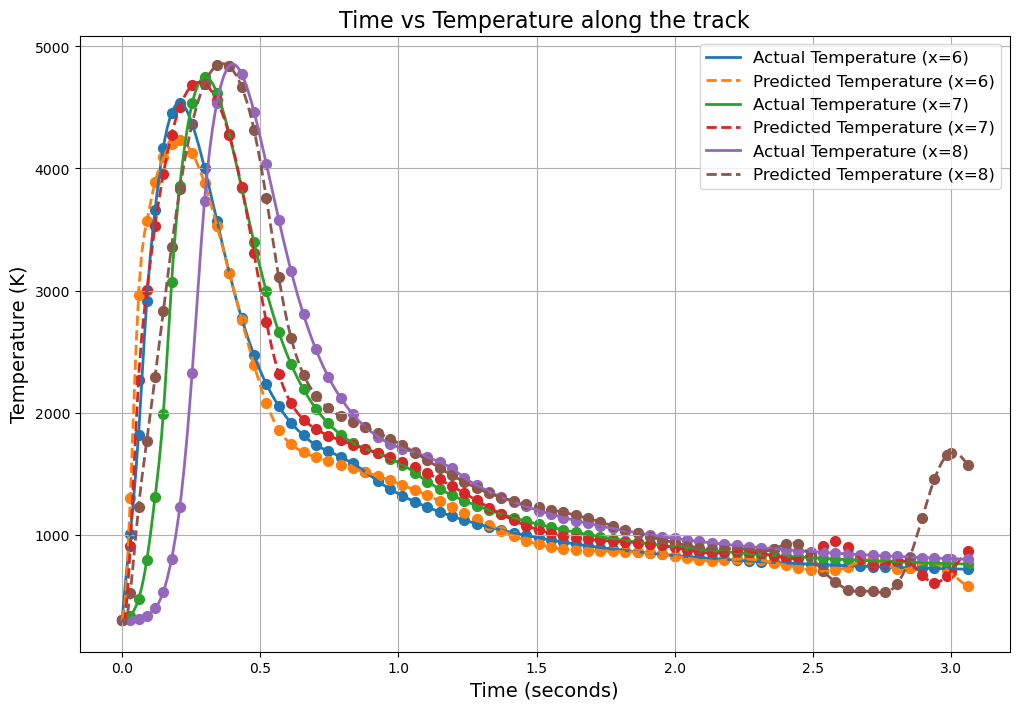

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Define dictionaries for actual and predicted temperatures
actual_data = {

    6: {
        'time': [0.0, 0.0298408, 0.0596816, 0.0895224, 0.119363, 0.149204, 0.179045, 0.208886, 0.253647, 0.298408, 0.343169, 0.387931, 0.432692, 0.477453, 0.522214, 0.566975, 0.611737, 0.656498, 0.701259, 0.74602, 0.790782, 0.835543, 0.880304, 0.925065, 0.969826, 1.01459, 1.05935, 1.10411, 1.14887, 1.19363, 1.23839, 1.28315, 1.32792, 1.37268, 1.41744, 1.4622, 1.50696, 1.55172, 1.59648, 1.64124, 1.68601, 1.73077, 1.77553, 1.82029, 1.86505, 1.90981, 1.95457, 1.99933, 2.0441, 2.08886, 2.13362, 2.17838, 2.22314, 2.2679, 2.31266, 2.35742, 2.40219, 2.44695, 2.49171, 2.53647, 2.58123, 2.62599, 2.67075, 2.71551, 2.76028, 2.80504, 2.8498, 2.89456, 2.93932, 2.98408, 3.0, 3.05887],
        'temperature':[298.15, 1005.35, 1820.84, 2918.44, 3658.27, 4170.63, 4452.92, 4540.34, 4364.82, 4005.24, 3572.47, 3147.0, 2774.38, 2471.2, 2234.12, 2053.25, 1915.16, 1813.79, 1733.67, 1686.78, 1636.24, 1584.1, 1515.08, 1438.66, 1373.84, 1318.7, 1269.93, 1226.51, 1187.4, 1151.98, 1119.75, 1090.29, 1063.28, 1038.42, 1015.49, 994.298, 974.662, 956.433, 939.487, 923.713, 909.009, 895.288, 882.472, 870.489, 859.275, 848.773, 838.931, 829.702, 821.04, 812.908, 805.269, 798.089, 791.339, 784.989, 779.014, 773.389, 768.094, 763.106, 758.407, 753.979, 749.805, 745.87, 742.159, 738.66, 735.36, 732.247, 729.31, 726.54, 723.926, 721.461, 720.602, 717.66]
    },
    7: {
        'time': [0.0, 0.0298408, 0.0596816, 0.0895224, 0.119363, 0.149204, 0.179045, 0.208886, 0.253647, 0.298408, 0.343169, 0.387931, 0.432692, 0.477453, 0.522214, 0.566975, 0.611737, 0.656498, 0.701259, 0.74602, 0.790782, 0.835543, 0.880304, 0.925065, 0.969826, 1.01459, 1.05935, 1.10411, 1.14887, 1.19363, 1.23839, 1.28315, 1.32792, 1.37268, 1.41744, 1.4622, 1.50696, 1.55172, 1.59648, 1.64124, 1.68601, 1.73077, 1.77553, 1.82029, 1.86505, 1.90981, 1.95457, 1.99933, 2.0441, 2.08886, 2.13362, 2.17838, 2.22314, 2.2679, 2.31266, 2.35742, 2.40219, 2.44695, 2.49171, 2.53647, 2.58123, 2.62599, 2.67075, 2.71551, 2.76028, 2.80504, 2.8498, 2.89456, 2.93932, 2.98408, 3.0, 3.05887],
        'temperature': [298.15, 336.718, 472.098, 789.748, 1305.22, 1985.9, 3066.5, 3856.92, 4533.12, 4748.04, 4621.58, 4280.6, 3841.8, 3395.02, 2994.24, 2661.34, 2396.64, 2191.54, 2033.37, 1911.85, 1820.84, 1750.64, 1704.16, 1667.49, 1623.11, 1575.28, 1507.13, 1436.19, 1375.68, 1324.21, 1278.91, 1238.41, 1201.88, 1168.73, 1138.48, 1110.76, 1085.27, 1061.77, 1040.04, 1019.9, 1001.2, 983.801, 967.592, 952.468, 938.339, 925.125, 912.755, 901.163, 890.291, 880.087, 870.502, 861.493, 853.019, 845.044, 837.534, 830.458, 823.788, 817.498, 811.563, 805.961, 800.671, 795.674, 790.952, 786.489, 782.268, 778.275, 774.497, 770.922, 767.538, 764.333, 763.216, 759.365]
    },
        8: {
        'time':[0.0, 0.0298408, 0.0596816, 0.0895224, 0.119363, 0.149204, 0.179045, 0.208886, 0.253647, 0.298408, 0.343169, 0.387931, 0.432692, 0.477453, 0.522214, 0.566975, 0.611737, 0.656498, 0.701259, 0.74602, 0.790782, 0.835543, 0.880304, 0.925065, 0.969826, 1.01459, 1.05935, 1.10411, 1.14887, 1.19363, 1.23839, 1.28315, 1.32792, 1.37268, 1.41744, 1.4622, 1.50696, 1.55172, 1.59648, 1.64124, 1.68601, 1.73077, 1.77553, 1.82029, 1.86505, 1.90981, 1.95457, 1.99933, 2.0441, 2.08886, 2.13362, 2.17838, 2.22314, 2.2679, 2.31266, 2.35742, 2.40219, 2.44695, 2.49171, 2.53647, 2.58123, 2.62599, 2.67075, 2.71551, 2.76028, 2.80504, 2.8498, 2.89456, 2.93932, 2.98408, 3.0, 3.05887],
        'temperature':  [298.15, 299.932, 308.431, 334.384, 397.214, 529.714, 800.234, 1224.94, 2327.96, 3732.96, 4537.94, 4842.12, 4774.95, 4465.65, 4035, 3579.01, 3159.22, 2804.19, 2518.52, 2294.49, 2120.77, 1986.07, 1882.27, 1803.94, 1744.26, 1705.68, 1674.39, 1637.75, 1594.78, 1542.92, 1467.21, 1405.27, 1353.43, 1308.12, 1267.78, 1231.5, 1198.63, 1168.67, 1141.23, 1116, 1092.73, 1071.21, 1051.26, 1032.73, 1015.47, 999.384, 984.362, 970.315, 957.162, 944.836, 933.271, 922.412, 912.207, 902.608, 893.574, 885.065, 877.044, 869.48, 862.343, 855.603, 849.236, 843.218, 837.527, 832.143, 827.046, 822.22, 817.648, 813.314, 809.206, 805.308, 803.948, 799.251]
    },

}

predicted_data = {

    6: {
        'time': [0.0, 0.0298408, 0.0596816, 0.0895224, 0.119363, 0.149204, 0.179045, 0.208886, 0.253647, 0.298408, 0.343169, 0.387931, 0.432692, 0.477453, 0.522214, 0.566975, 0.611737, 0.656498, 0.701259, 0.74602, 0.790782, 0.835543, 0.880304, 0.925065, 0.969826, 1.01459, 1.05935, 1.10411, 1.14887, 1.19363, 1.23839, 1.28315, 1.32792, 1.37268, 1.41744, 1.4622, 1.50696, 1.55172, 1.59648, 1.64124, 1.68601, 1.73077, 1.77553, 1.82029, 1.86505, 1.90981, 1.95457, 1.99933, 2.0441, 2.08886, 2.13362, 2.17838, 2.22314, 2.2679, 2.31266, 2.35742, 2.40219, 2.44695, 2.49171, 2.53647, 2.58123, 2.62599, 2.67075, 2.71551, 2.76028, 2.80504, 2.8498, 2.89456, 2.93932, 2.98408, 3.0, 3.05887],
        'temperature': [304.4098, 1301.4401, 2965.3557, 3566.1406, 3887.5063, 4090.8992, 4202.161, 4229.6655, 4127.494, 3879.245, 3532.6206, 3144.766, 2758.3257, 2393.5542, 2077.9026, 1860.8079, 1741.0131, 1675.7913, 1634.4641, 1602.4897, 1573.3547, 1544.0908, 1513.3236, 1480.402, 1445.014, 1407.0172, 1366.3926, 1323.2156, 1277.6892, 1230.1626, 1181.1705, 1131.4875, 1082.1766, 1034.6896, 990.78796, 952.3988, 921.18994, 898.0476, 882.7018, 873.76086, 869.15625, 866.73145, 864.6743, 861.6688, 856.81323, 849.43396, 838.95984, 825.0586, 808.45953, 792.8801, 785.7565, 790.60803, 798.54346, 798.86865, 789.13586, 771.9727, 750.98096, 729.40125, 710.73083, 700.547, 707.6907, 739.0643, 780.99994, 793.598, 760.5171, 720.0648, 725.0484, 765.93933, 765.96655, 713.18066, 685.18506, 577.3716]
    },
    7: {
        'time': [0.0, 0.0298408, 0.0596816, 0.0895224, 0.119363, 0.149204, 0.179045, 0.208886, 0.253647, 0.298408, 0.343169, 0.387931, 0.432692, 0.477453, 0.522214, 0.566975, 0.611737, 0.656498, 0.701259, 0.74602, 0.790782, 0.835543, 0.880304, 0.925065, 0.969826, 1.01459, 1.05935, 1.10411, 1.14887, 1.19363, 1.23839, 1.28315, 1.32792, 1.37268, 1.41744, 1.4622, 1.50696, 1.55172, 1.59648, 1.64124, 1.68601, 1.73077, 1.77553, 1.82029, 1.86505, 1.90981, 1.95457, 1.99933, 2.0441, 2.08886, 2.13362, 2.17838, 2.22314, 2.2679, 2.31266, 2.35742, 2.40219, 2.44695, 2.49171, 2.53647, 2.58123, 2.62599, 2.67075, 2.71551, 2.76028, 2.80504, 2.8498, 2.89456, 2.93932, 2.98408, 3.0, 3.05887],
        'temperature':[301.9312, 905.4263, 2270.3062, 3001.7876, 3529.122, 3952.6943, 4276.0625, 4502.2607, 4680.521, 4693.472, 4557.2476, 4274.8823, 3848.6897, 3304.795, 2742.951, 2319.5293, 2076.2913, 1943.8196, 1865.4528, 1812.9735, 1772.622, 1737.4137, 1703.6691, 1669.3269, 1633.0867, 1593.9977, 1551.316, 1504.4989, 1453.3523, 1398.2114, 1340.1158, 1280.8257, 1222.5864, 1167.7509, 1118.2328, 1075.2924, 1039.5017, 1010.8811, 989.0261, 973.14905, 962.09106, 954.3966, 948.4475, 942.6687, 935.63684, 926.0945, 912.9789, 895.8175, 875.88477, 857.8834, 849.85364, 855.15405, 863.00793, 860.9252, 847.2273, 827.28845, 809.8428, 808.177, 839.7367, 904.4912, 944.80176, 899.16406, 804.1138, 748.4735, 764.0548, 787.3086, 768.3873, 671.2781, 607.15076, 663.6804, 704.51135, 867.23755]
    },

    8: {
        'time': [0.0, 0.05, 0.495412, 0.541287, 1.18354, 2.14691, 2.97265, 3.0],
        'temperature':  [299.88834, 525.9823, 1226.0074, 1766.8885, 2291.461, 2833.2563, 3359.2656, 3828.001, 4366.554, 4695.9717, 4844.1533, 4835.566, 4669.1914, 4316.559, 3755.9856, 3109.0305, 2611.1487, 2312.191, 2139.6938, 2036.8749, 1971.3499, 1923.3296, 1880.6969, 1836.5933, 1787.6783, 1732.9702, 1673.209, 1610.3895, 1547.2965, 1486.8376, 1431.3877, 1382.3668, 1340.1912, 1304.5261, 1274.4984, 1248.9208, 1226.3672, 1205.2024, 1183.6997, 1160.3177, 1134.1027, 1105.059, 1074.1182, 1042.7485, 1012.36426, 983.963, 957.9778, 933.98425, 911.1677, 891.407, 881.645, 884.7074, 887.1223, 877.3037, 866.0188, 881.0194, 925.39124, 920.88477, 822.49475, 702.156, 613.3891, 550.25806, 537.32764, 536.2299, 529.539, 599.46, 811.98193, 1133.915, 1455.6112, 1649.4412, 1671.5701, 1572.0616]
    }

}

# Plotting the provided data points and predictions
plt.figure(figsize=(12, 8))

# Loop through each x value in actual_data
for x in actual_data.keys():
    actual_times = actual_data[x]['time']
    actual_temps = actual_data[x]['temperature']
    predicted_temps = predicted_data[x]['temperature']
    
    # Generate smooth data points using interpolation
    time_smooth = np.linspace(min(actual_times), max(actual_times), 300)
    
    actual_spline = make_interp_spline(actual_times, actual_temps, k=3)
    predicted_spline = make_interp_spline(actual_times, predicted_temps, k=3)
    
    actual_temperatures_smooth = actual_spline(time_smooth)
    predicted_temperatures_smooth = predicted_spline(time_smooth)
    
    # Plot actual and predicted data with smoothing
    plt.plot(time_smooth, actual_temperatures_smooth, '-', label=f'Actual Temperature (x={x})', linewidth=2)
    plt.plot(time_smooth, predicted_temperatures_smooth, '--', label=f'Predicted Temperature (x={x})', linewidth=2)
    plt.scatter(actual_times, actual_temps, s=50)  # original points for actual temperature
    plt.scatter(actual_times, predicted_temps, s=50)  # original points for predicted temperature

plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Temperature (K)', fontsize=14)
plt.title('Time vs Temperature along the track', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()


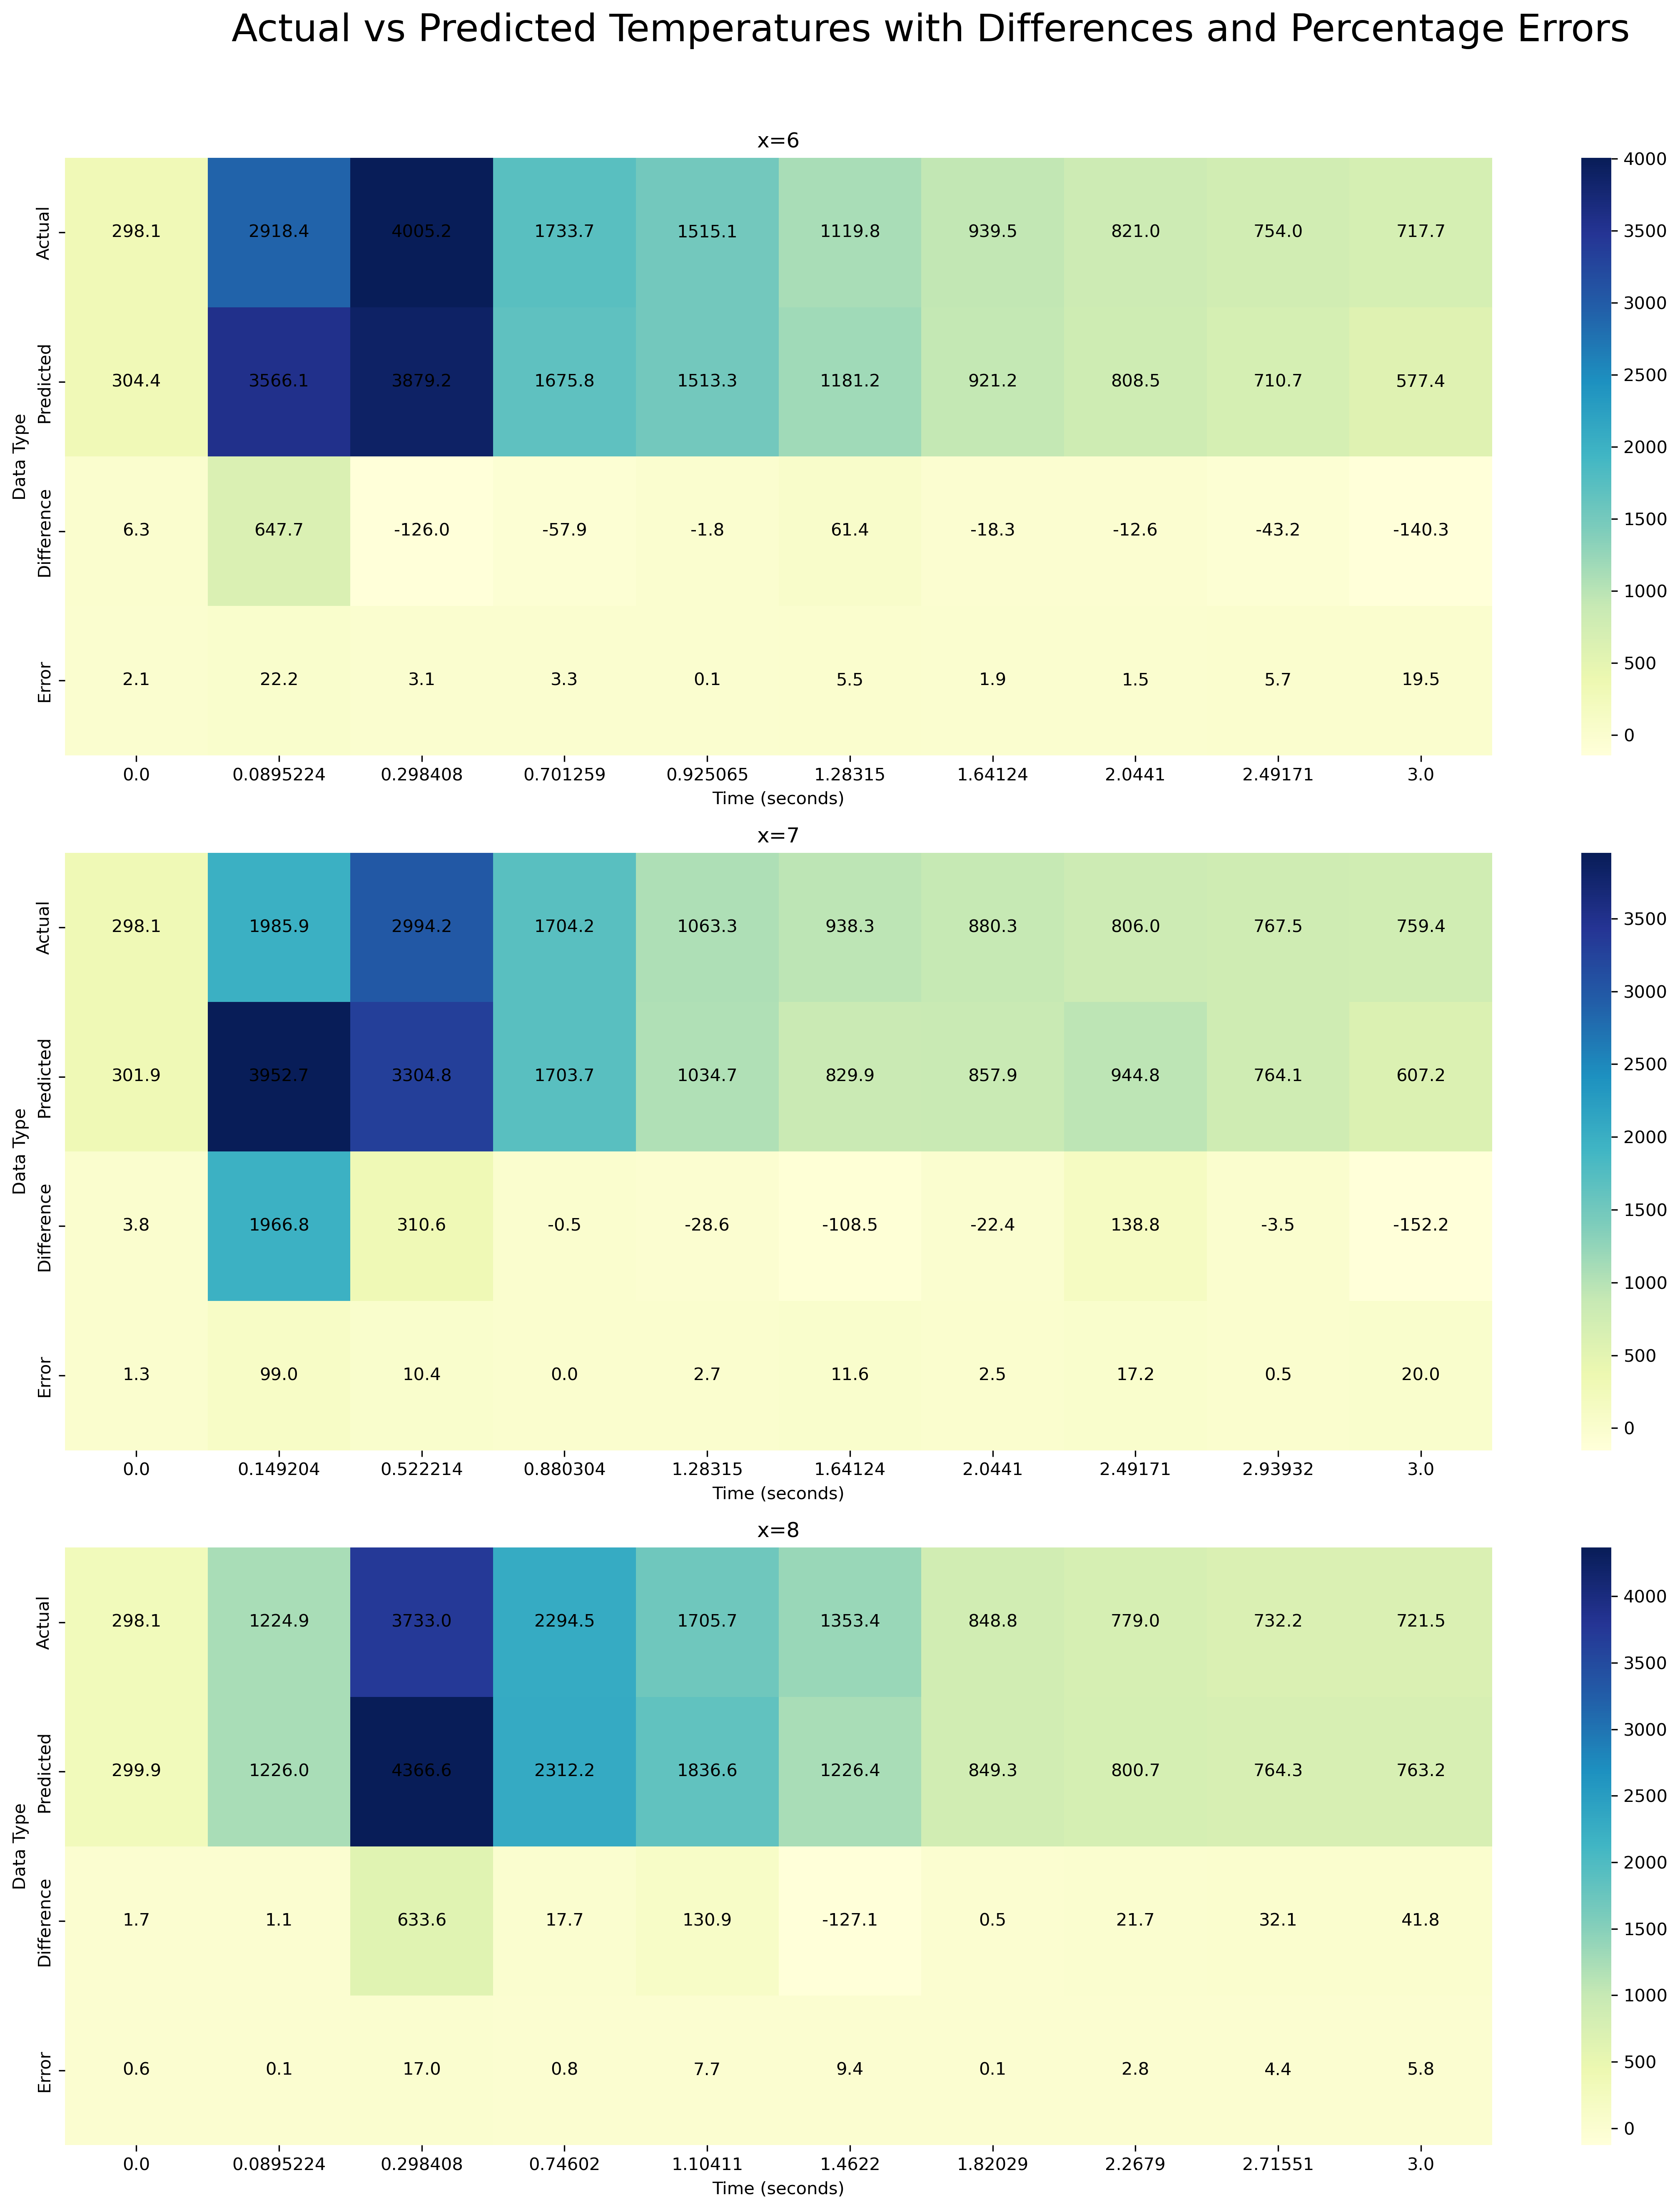

Average Percentage Error: 9.30%


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reduced data points for actual and predicted temperatures
actual_data_reduced = {
    6: {
        'time': [0.0, 0.0895224, 0.298408, 0.701259, 0.925065, 1.28315, 1.64124, 2.0441, 2.49171, 3.0],
        'temperature': [298.15, 2918.44, 4005.24, 1733.67, 1515.08, 1119.75, 939.487, 821.04, 753.979, 717.66]
    },
    7: {
        'time': [0.0, 0.149204, 0.522214, 0.880304, 1.28315, 1.64124, 2.0441, 2.49171, 2.93932, 3.0],
        'temperature': [298.15, 1985.9, 2994.24, 1704.16, 1063.28, 938.339, 880.291, 805.961, 767.538, 759.365]
    },
    8: {
        'time': [0.0, 0.0895224, 0.298408, 0.74602, 1.10411, 1.4622, 1.82029, 2.2679, 2.71551, 3.0],
        'temperature': [298.15, 1224.94, 3732.96, 2294.49, 1705.68, 1353.43, 848.773, 779.014, 732.247, 721.461]
    }
}

predicted_data_reduced = {
    6: {
        'time': [0.0, 0.0895224, 0.298408, 0.701259, 0.925065, 1.28315, 1.64124, 2.0441, 2.49171, 3.0],
        'temperature': [304.4098, 3566.1406, 3879.245, 1675.7913, 1513.3236, 1181.1705, 921.18994, 808.45953, 710.73083, 577.3716]
    },
    7: {
        'time': [0.0, 0.149204, 0.522214, 0.880304, 1.28315, 1.64124, 2.0441, 2.49171, 2.93932, 3.0],
        'temperature': [301.9312, 3952.6943, 3304.795, 1703.6691, 1034.6896, 829.861, 857.8834, 944.80176, 764.0548, 607.15076]
    },
    8: {
        'time': [0.0, 0.0895224, 0.298408, 0.74602, 1.10411, 1.4622, 1.82029, 2.2679, 2.71551, 3.0],
        'temperature': [299.88834, 1226.0074, 4366.554, 2312.191, 1836.5933, 1226.3672, 849.273, 800.671, 764.333, 763.216]
    }
}

# Calculate differences and percentage errors
differences = {}
percentage_errors = {}

for x in actual_data_reduced.keys():
    actual_temps = np.array(actual_data_reduced[x]['temperature'])
    predicted_temps = np.array(predicted_data_reduced[x]['temperature'])
    differences[x] = predicted_temps - actual_temps
    percentage_errors[x] = np.abs((actual_temps - predicted_temps) / actual_temps) * 100

# Function to plot heatmaps
def plot_heatmaps(ax, actual, predicted, difference, error, x):
    data_matrix = np.vstack((actual, predicted, difference, error))
    labels = ['Actual', 'Predicted', 'Difference', 'Error']
    
    sns.heatmap(data_matrix, annot=True, fmt=".1f", cmap="YlGnBu", xticklabels=actual_data_reduced[x]['time'], yticklabels=labels, cbar=True, ax=ax, annot_kws={"color": "black"})
    ax.set_title(f"x={x}")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Data Type")

# Create subplots
fig, axs = plt.subplots(len(actual_data_reduced), 1, figsize=(15, 6 * len(actual_data_reduced)), dpi=300)

# Plot heatmaps for each x value
for i, x in enumerate(actual_data_reduced.keys()):
    plot_heatmaps(axs[i], actual_data_reduced[x]['temperature'], predicted_data_reduced[x]['temperature'], differences[x], percentage_errors[x], x)

fig.suptitle('Actual vs Predicted Temperatures with Differences and Percentage Errors', fontsize=22)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Calculate the average percentage error
all_percentage_errors = np.concatenate([percentage_errors[x] for x in percentage_errors.keys()])
average_percentage_error = np.mean(all_percentage_errors)
print(f'Average Percentage Error: {average_percentage_error:.2f}%')
